In [1]:
import sys 
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm')
import jax.numpy as jnp
import jax.random as jr
from jax import lax, vmap, debug
from jax.scipy.special import logsumexp as lse 
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from utils import map_sims, resample
from ABC import smc_abc
from parameters import initialize, log_prior
from parameters import sample_ssm_params, initialize, to_train_array
from ssm import LGSSM
from dynamax.utils.bijectors import RealToPSDBijector # type: ignore
from parameters import params_from_tree, sample_ssm_params, initialize, to_train_array, log_prior, get_unravel_fn, join_trees, tree_from_params
from jaxtyping import Array

from jax import numpy as jnp
from jax import random as jr
from matplotlib import pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd
from simulation_inference import sample_and_train


In [2]:
num_timesteps = 100
num_rounds = 5
# SSM model parameters
state_dim = 1
emission_dim = 1
input_dim = 0

initial_mean = jnp.zeros(state_dim)
initial_covariance = jnp.eye(state_dim) * 0.1

dynamics_weights  = 0.9 * jnp.eye(state_dim)
dynamics_bias = jnp.zeros(state_dim)
dynamics_input_weights = jnp.zeros((state_dim, input_dim))
dynamics_covariance = jnp.eye(state_dim) * 0.1

emission_weights = jnp.eye(emission_dim, state_dim)
emission_bias = jnp.zeros(emission_dim)
emission_input_weights = jnp.zeros((emission_dim, input_dim))
emission_covariance = jnp.eye(emission_dim) * 0.1

# Initialize props and prior
m = state_dim * (state_dim + 1) // 2
dynamics_covariance_dist = tfd.MultivariateNormalDiag(loc=jnp.zeros(m), scale_diag=0.1*jnp.ones(m))

param_names = [['mean', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov'],
               ['weights', 'bias', 'input_weights', 'cov']]
prior_fields = [[initial_mean, initial_covariance],
                [dynamics_weights, dynamics_bias, dynamics_input_weights, dynamics_covariance_dist],
                [emission_weights, emission_bias, emission_input_weights, emission_covariance]]
is_constrained_tree = [[True, True], 
                       [True, True, True, False], 
                       [True, True, True, True]]
constrainers  = [[None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector],
                [None, None, None, RealToPSDBijector]]

props, prior = initialize(prior_fields, param_names, constrainers)

seed = 121241278123  
key = jr.PRNGKey(seed)  

key, subkey = jr.split(key)
lgssm = LGSSM(state_dim, emission_dim)
params_sample = sample_ssm_params(subkey, prior, 10)
true_param = params_sample[0]
example_param = params_sample[1]
true_param_vec = to_train_array(true_param, props)
true_param.from_unconstrained(props)
key, subkey = jr.split(key)
states, observations = lgssm.simulate(subkey, true_param, num_timesteps)

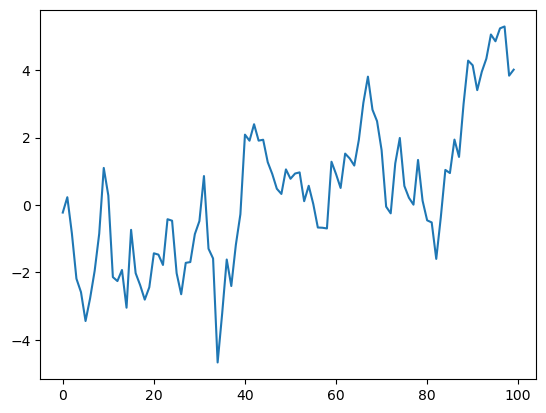

In [3]:
plt.plot(observations)
plt.show()

/usr/local/Caskroom/miniforge/base/envs/jaxenv/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


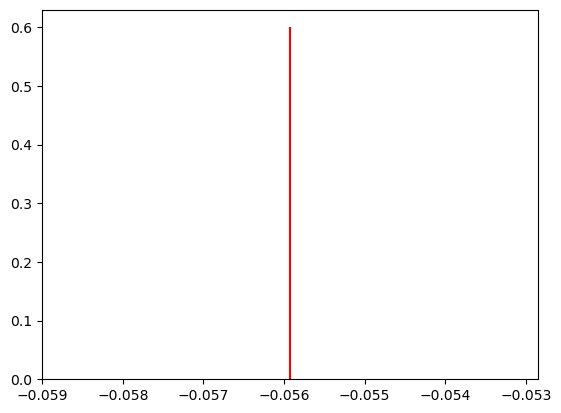

3.0


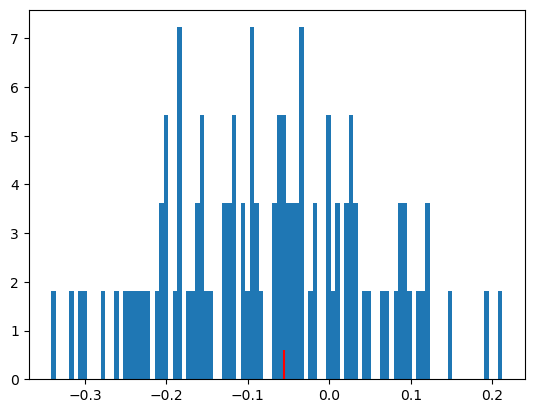

3.0
2.9000000953674316


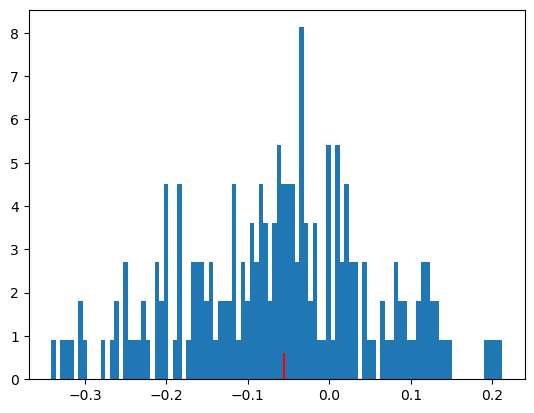

3.0
2.9000000953674316
2.799999952316284


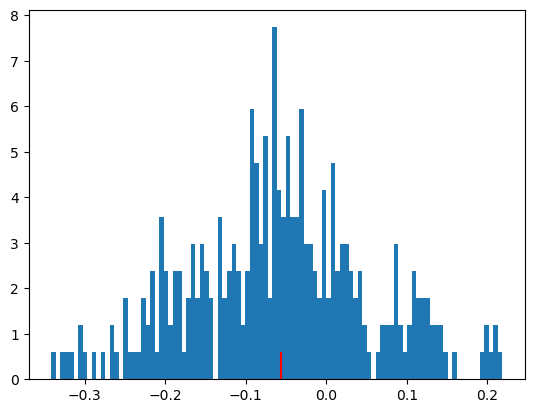

3.0
2.9000000953674316
2.799999952316284
2.700000047683716


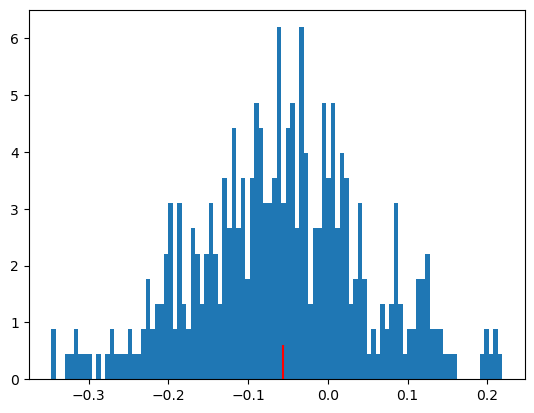

3.0
2.9000000953674316
2.799999952316284
2.700000047683716
2.5999999046325684


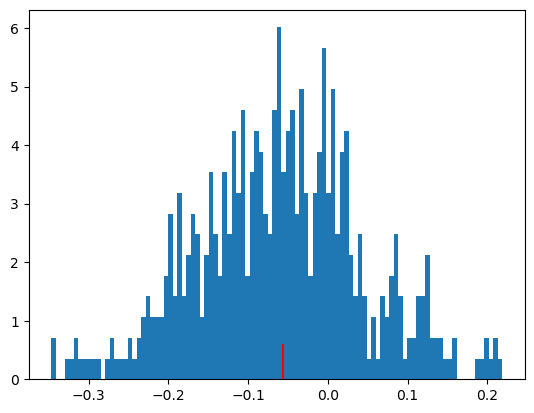

3.0
2.9000000953674316
2.799999952316284
2.700000047683716
2.5999999046325684
2.5


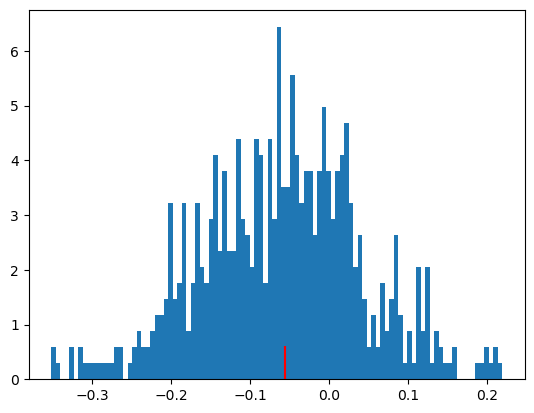

3.0
2.9000000953674316
2.799999952316284
2.700000047683716
2.5999999046325684
2.5
2.4000000953674316


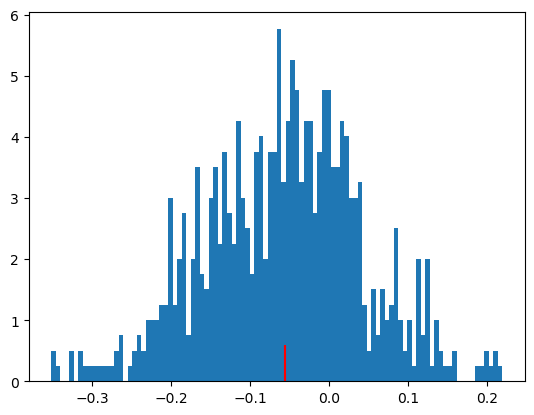

3.0
2.9000000953674316
2.799999952316284
2.700000047683716
2.5999999046325684
2.5
2.4000000953674316
2.299999952316284


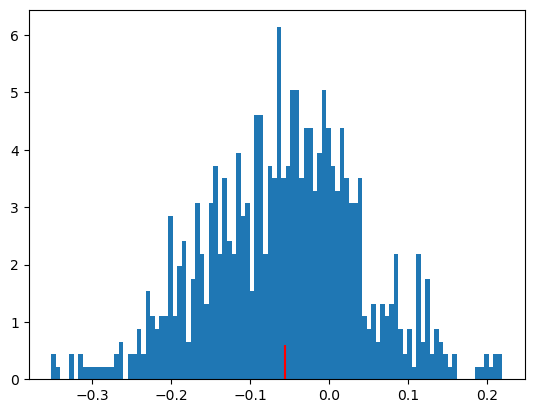

3.0
2.9000000953674316
2.799999952316284
2.700000047683716
2.5999999046325684
2.5
2.4000000953674316
2.299999952316284
2.200000047683716


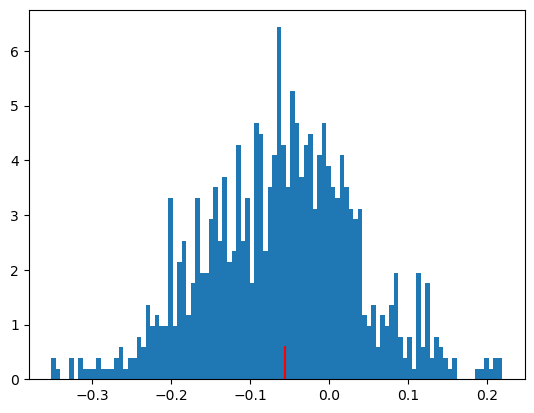

In [4]:
for r in range(10):
    out = smc_abc(key, observations, lgssm, example_param, props, prior, 100, r)
    plt.hist(out[0].flatten(), bins=100, density=True)
    plt.vlines(true_param_vec, 0, 0.6, color='red')
    plt.show()